# Import

In [1]:
import csv
import os
import sys

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

## Add configuration file

In [4]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [5]:
from ALL import config
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_error_1_layout import layout
from util import *

## Set condition

In [6]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [7]:
data_type = "AgNewsTitle"
vectorize_type = "doc2vec"

# Read data

In [8]:
vector_dims = config["vectorize"]["doc2vec"]["dims"]
model_nums = config["clustering"]["gmm"]["max_model_num"]
vector_model_num = config["vectorize"]["doc2vec"]["max_model_num"]
covariance_types = config["clustering"]["gmm"]["covariance_types"]

In [11]:
coherences = {}
for vector_dim in tqdm(vector_dims):
    coherence_path = f"../../Postprocessing/data/{data_type}/{vectorize_type}/GMM/coherence/{vector_dim}.csv"
    coherence = pd.read_csv(coherence_path, index_col=0)
    coherences[vector_dim] = coherence

100%|██████████| 9/9 [00:00<00:00, 501.49it/s]


In [12]:
coherence_lda_path = f"../../Postprocessing/data/{data_type}/LDA/coherence.csv"
coherence_lda = pd.read_csv(coherence_lda_path, index_col=0)
describe_lda, _ = get_describe(coherence_lda, axis=0)

# Data shaping

In [13]:
coherence_df = {covariance_type: pd.DataFrame() for covariance_type in covariance_types}
for covariance_type in covariance_types:
    _coherence_df = {
        vector_dim: coherences[vector_dim].loc[:, covariance_type]
        for vector_dim in vector_dims
    }
    coherence_df[covariance_type] = pd.concat(_coherence_df, axis=1)

In [14]:
# 統計値の計算
describe = {covariance_type: pd.DataFrame() for covariance_type in covariance_types}
for covariance_type in covariance_types:
    describe[covariance_type], describe_keys = get_describe(
        coherence_df[covariance_type], axis=0
    )

In [15]:
data = {describe_key: pd.DataFrame() for describe_key in describe_keys}

for describe_key in describe_keys:
    # covariance_typeについてデータを結合
    _data = {
        covariance_type: describe[covariance_type][describe_key]
        for covariance_type in covariance_types
    }
    data[describe_key] = pd.concat(_data, axis=1)

# Data plot

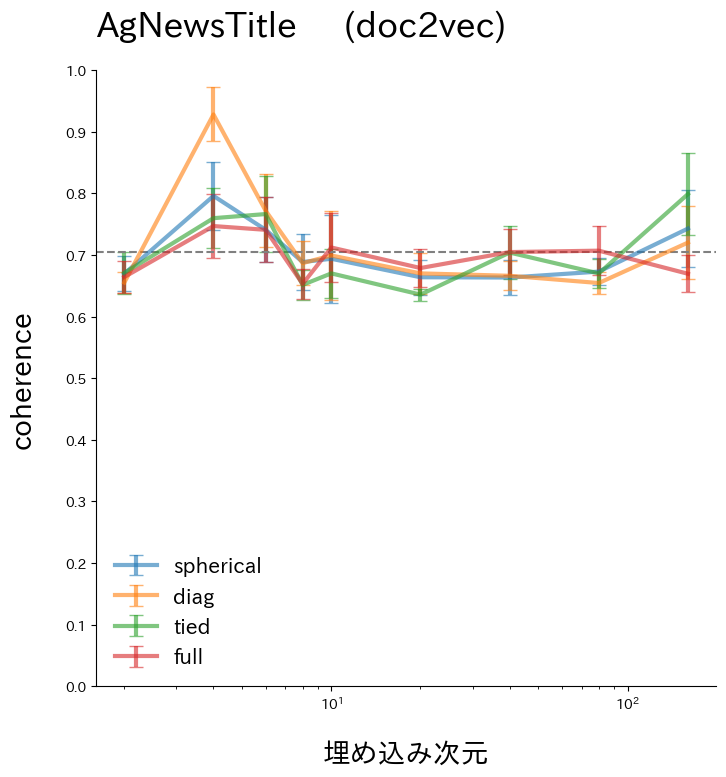

In [16]:
fig_path = f"../data/figure/{data_type}/{vectorize_type}/GMM/coherence.pdf"
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
ax.set_xscale('log')
line_plot_error_1(
    data["mean"],
    error_low = data["std"],
    error_upper = data["std"],
    fig=fig,
    ax=ax,
    title=f"{data_type}     ({vectorize_type})",
    layout=layout,
    xlabel="埋め込み次元",
    ylabel="coherence",
    yticks=np.arange(0, 1.1, 0.1),
    path=fig_path,
)
ax.axhline(y=describe_lda["mean"].to_numpy(), linestyle="dashed", color="gray")